In [18]:
cd ../

C:\Users\yulya\PycharmProjects


In [19]:
import time
import math
import string
import pandas as pd
import numpy as np
from random import randint
from typing import Any, Tuple, List

In [3]:
from regex.parser import RegexParser
from regex.regex import *

In [4]:
with open("datasets/dataset.csv", "r") as f:
    REGEXES = f.read().split("\n")[:-1]

## Approximation 

In [5]:
def get_approximation(str_regex: str) -> Tuple[str, int]:
    
    def approximate(regex: Regex, height: int = 0) -> Tuple[Optional[Regex], int]:
        if isinstance(regex, BaseRegex):
            return regex, height
        if isinstance(regex, AlternativeRegex) or isinstance(regex, ConcatenationRegex):
            apps = [approximate(value, height) for value in regex.value]
            return apps[np.argmax([app[1] for app in apps])]
        if isinstance(regex, StarRegex):
            height += 1
            if isinstance(regex.value, BaseRegex):
                return regex, height
            apps = [approximate(value, height) for value in regex.value.value]
            max_idx = np.argmax([app[1] for app in apps])
            return StarRegex(apps[max_idx][0], 1), apps[max_idx][1]
    
    regex = RegexParser(str_regex, [1] * len(str_regex)).parse()
    approximation = approximate(regex)
    return str(approximation[0]), len(str(regex)) - approximation[1]

In [6]:
approx_data = {
    "regex": [],
    "approximation": [],
    "iter_length": [],
    "distance": []
}

for regex in REGEXES:
    approx = get_approximation(regex)
    approx_data["regex"].append(str(RegexParser(regex, [100] * len(regex)).parse()))
    approx_data["approximation"].append(approx[0])
    approx_data["iter_length"].append(len(approx[0]) - 1)
    approx_data["distance"].append(approx[1])

In [7]:
approx_df = pd.DataFrame(approx_data)
approx_df

,regex,approximation,iter_length,distance
0,(l*l)*l*,l**,2,6
1,k*|s***,s***,3,4
2,Q*(Q|Q**Q)*Q*,Q***,3,10
3,C**,C**,2,1
4,H*|g**,g**,2,4
...,...,...,...,...
75,Jd***,d***,3,2
76,x*h(Q*|P)*,Q**,2,8
77,(Y*|m*)*,Y**,2,6
78,((f*k|r**P**)*|M)*,r****,4,14


In [8]:
approx_df.describe()

,iter_length,distance
count,80.000000,80.000000
mean,2.712500,7.675000
std,0.888659,5.819598
min,1.000000,1.000000
25%,2.000000,2.750000
50%,3.000000,6.500000
75%,3.000000,12.000000
max,5.000000,24.000000


In [9]:
approx_df.to_csv("experiments/approximation.csv", index=False)

In [10]:
approx_df = approx_df[(approx_df["distance"] >= 12) | (approx_df["distance"] <= 2)]

In [11]:
len(approx_df)

41

## Learning

In [6]:
from pattern.pattern import NEVariable, NEPattern

python main.py -d datasets/approx_dataset.csv -o

Length=2: 100%|██████████████████████████████████████████| 2/2 [00:00<?, ?it/s, pattern=f\*]

Length=3: 100%|██████████████████████████████████████████| 37/37 [00:00<?, ?it/s, pattern=x1\*\*]

Length=4: 100%|██████████████████████████████████████████| 26/26 [00:00<?, ?it/s, pattern=x1\*\*\*]

Length=5: 100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 768.04it/s, pattern=x1\*\*\*\*] 

Length=6: 100%|██████████████████████████████████████████| 3/3 [00:00<?, ?it/s, pattern=x1\*\*\*\*\*]


Result: x1\*

In [7]:
result = NEPattern([NEVariable(), "*"])

## Filtering

In [20]:
from typing import Callable, Dict
import matplotlib.pyplot as plt

In [24]:
def get_letters(word: str) -> List[str]:
    letters = []
    alphabet = list(string.ascii_lowercase) + \
               list(string.ascii_uppercase)
    for c in word:
        if c in alphabet:
            letters.append(c)
    return letters


def measure_time(func: Callable, *params) -> Tuple: # in seconds
    t1 = time.perf_counter()
    result = func(*params)
    t2 = time.perf_counter()
    return result, t2 - t1


def measure_match(regex: Any, words: List[str]) -> Tuple:
    length, time = [], []
    for word in words:
        length.append(len(word))
        time.append(measure_time(regex.match, word)[1])
    return length, time
    

def is_exp(
        length: List[int], 
        time: List[float], 
        c1_range: Iterator[int], 
        c2_range: Iterator[int]) -> bool:
    for c1 in c1_range:
        for c2 in c2_range:
            exp = False
            for l, t in zip(length, time):
                if t >= 10**c1 * l**4 + 10**c2:
                    exp = True
                else:
                    exp = False
                    break
            if exp:
                return True
    return False


def generate_word_group(
    step: int = 10, max_n: int = 50, 
    length_range: List[int] = [3, 30],
    alphabet: Optional[List[str]] = None) -> List[str]:
    base_alphabet = list(string.ascii_lowercase + string.ascii_uppercase)
    if alphabet is None:
        alphabet = list(string.ascii_lowercase + string.ascii_uppercase)
    alphabet_len = len(alphabet)
    pattern = []
    mask = []
    # length = randint(length_range[0], length_range[1])
    length = len(alphabet) + 1
    for i in range(length):
        if i < len(alphabet):
            pattern.append(alphabet[i]) # randint(0, len(alphabet)-1)
        else:
            pattern.append(base_alphabet[randint(0, len(base_alphabet) - 1)])
        mask.append(randint(0, 1))
    if all([m == 0 for m in mask]):
        mask[randint(0, length - 1)] = 1
    return (" ".join([p + "^n" if mask[i] else p for i, p in enumerate(pattern)]), 
            ["".join([p * n if mask[i] else p for i, p in enumerate(pattern)]) for n in range(0, max_n + 1, step)])

In [25]:
def get_exp_measurements(
        regex: str, 
        max_iter: int = 10, 
        step: int = 10, max_n: int = 50) -> pd.DataFrame:
    exp = {"length": [], "time": [], "pattern": []}
    alphabet = get_letters(regex)
    regex = RegexParser(regex, [100] * len(regex)).parse()
    for i in range(max_iter):
        pattern, words = generate_word_group(step, max_n, alphabet=alphabet)
        length, time = measure_match(regex, words)
        if is_exp(length, time, range(2, -13, -1), range(2, -10, -1)):
            exp["length"].append(length)
            exp["time"].append(time)
            exp["pattern"].append(pattern)
    return pd.DataFrame(exp)


def unite_start(time1, time2):
    if time1[0] != time2[0]:
        d = time1[0] - time2[0]
        return [t2 + d for t2 in time2]
    return time2
    

def check_approximation(
        regex: str, depth: str, 
        max_iter: int = 1, 
        step: int = 10, max_n: int = 50) -> List[Any]:
    min_bound = RegexParser("a" + "*" * depth, [100] * depth).parse()
    max_bound = RegexParser("a*" + "*" * depth, [100] * (depth + 1)).parse()
    regex_results = get_exp_measurements(regex, max_iter, step, max_n)
    plots = []
    for row in regex_results.iterrows():
        regex_length = row[1]["length"]
        regex_time = row[1]["time"]
        words = ["a" * (l - 1) + "b" for l in regex_length]
        plots.append({
            "pattern": row[1]["pattern"],
            "min_time": unite_start(regex_time, measure_match(min_bound, words)[1]),
            "max_time": unite_start(regex_time, measure_match(max_bound, words)[1]),
            "regex_time": regex_time,
            "length": regex_length
        })
    return plots

In [64]:
def plot_dependencies(plots: List[Any], cols: int = 3, figsize: Tuple[int, int] = (25, 17)):
    rows = math.ceil(len(plots) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=figsize) #(max(rows, cols) * 2 * 5, cols * 5))
    i = 0
    if rows > 1:
        for row in range(rows):
            if i >= len(plots):
                break
            for col in range(cols):
                if i >= len(plots):
                    break
                axs[row, col].plot(plots[i]["length"], plots[i]["regex_time"], "tab:green", label="regex")
                axs[row, col].plot(plots[i]["length"], plots[i]["max_time"], "tab:red", label="max")
                axs[row, col].plot(plots[i]["length"], plots[i]["min_time"], "tab:blue", label="min")
                axs[row, col].set_title(plots[i]["pattern"])
                axs[row, col].legend()
                i += 1
    else:
        for col in range(cols):
            if i >= len(plots):
                break
            axs[col].plot(plots[i]["length"], plots[i]["regex_time"], "tab:green", label="regex")
            axs[col].plot(plots[i]["length"], plots[i]["max_time"], "tab:red", label="max")
            axs[col].plot(plots[i]["length"], plots[i]["min_time"], "tab:blue", label="min")
            axs[col].set_title(plots[i]["pattern"])
            axs[col].legend()
            i += 1
    for ax in axs.flat:
        ax.set(xlabel='Step', ylabel='Time, sec')
    plt.show();

In [88]:
approx_df["match"] = approx_df["regex"].apply(result.match)

In [89]:
approx_df[~approx_df["match"]]

,regex,approximation,iter_length,distance,match
18,(r(k(u*d*)*)*O)*Z,u****,4,13,False
21,QJ*|q|(M(un)*|B)*|C,u**,2,17,False
24,(o*|I|dC)**L*|F,o***,3,12,False
27,YN(l**|u*)a(Hc|E*)|l,l**,2,18,False
28,((wN*O*d)**|l)*X,N****,4,12,False


In [91]:
approx_df.to_csv("experiments/second_filtering.csv", index=False)

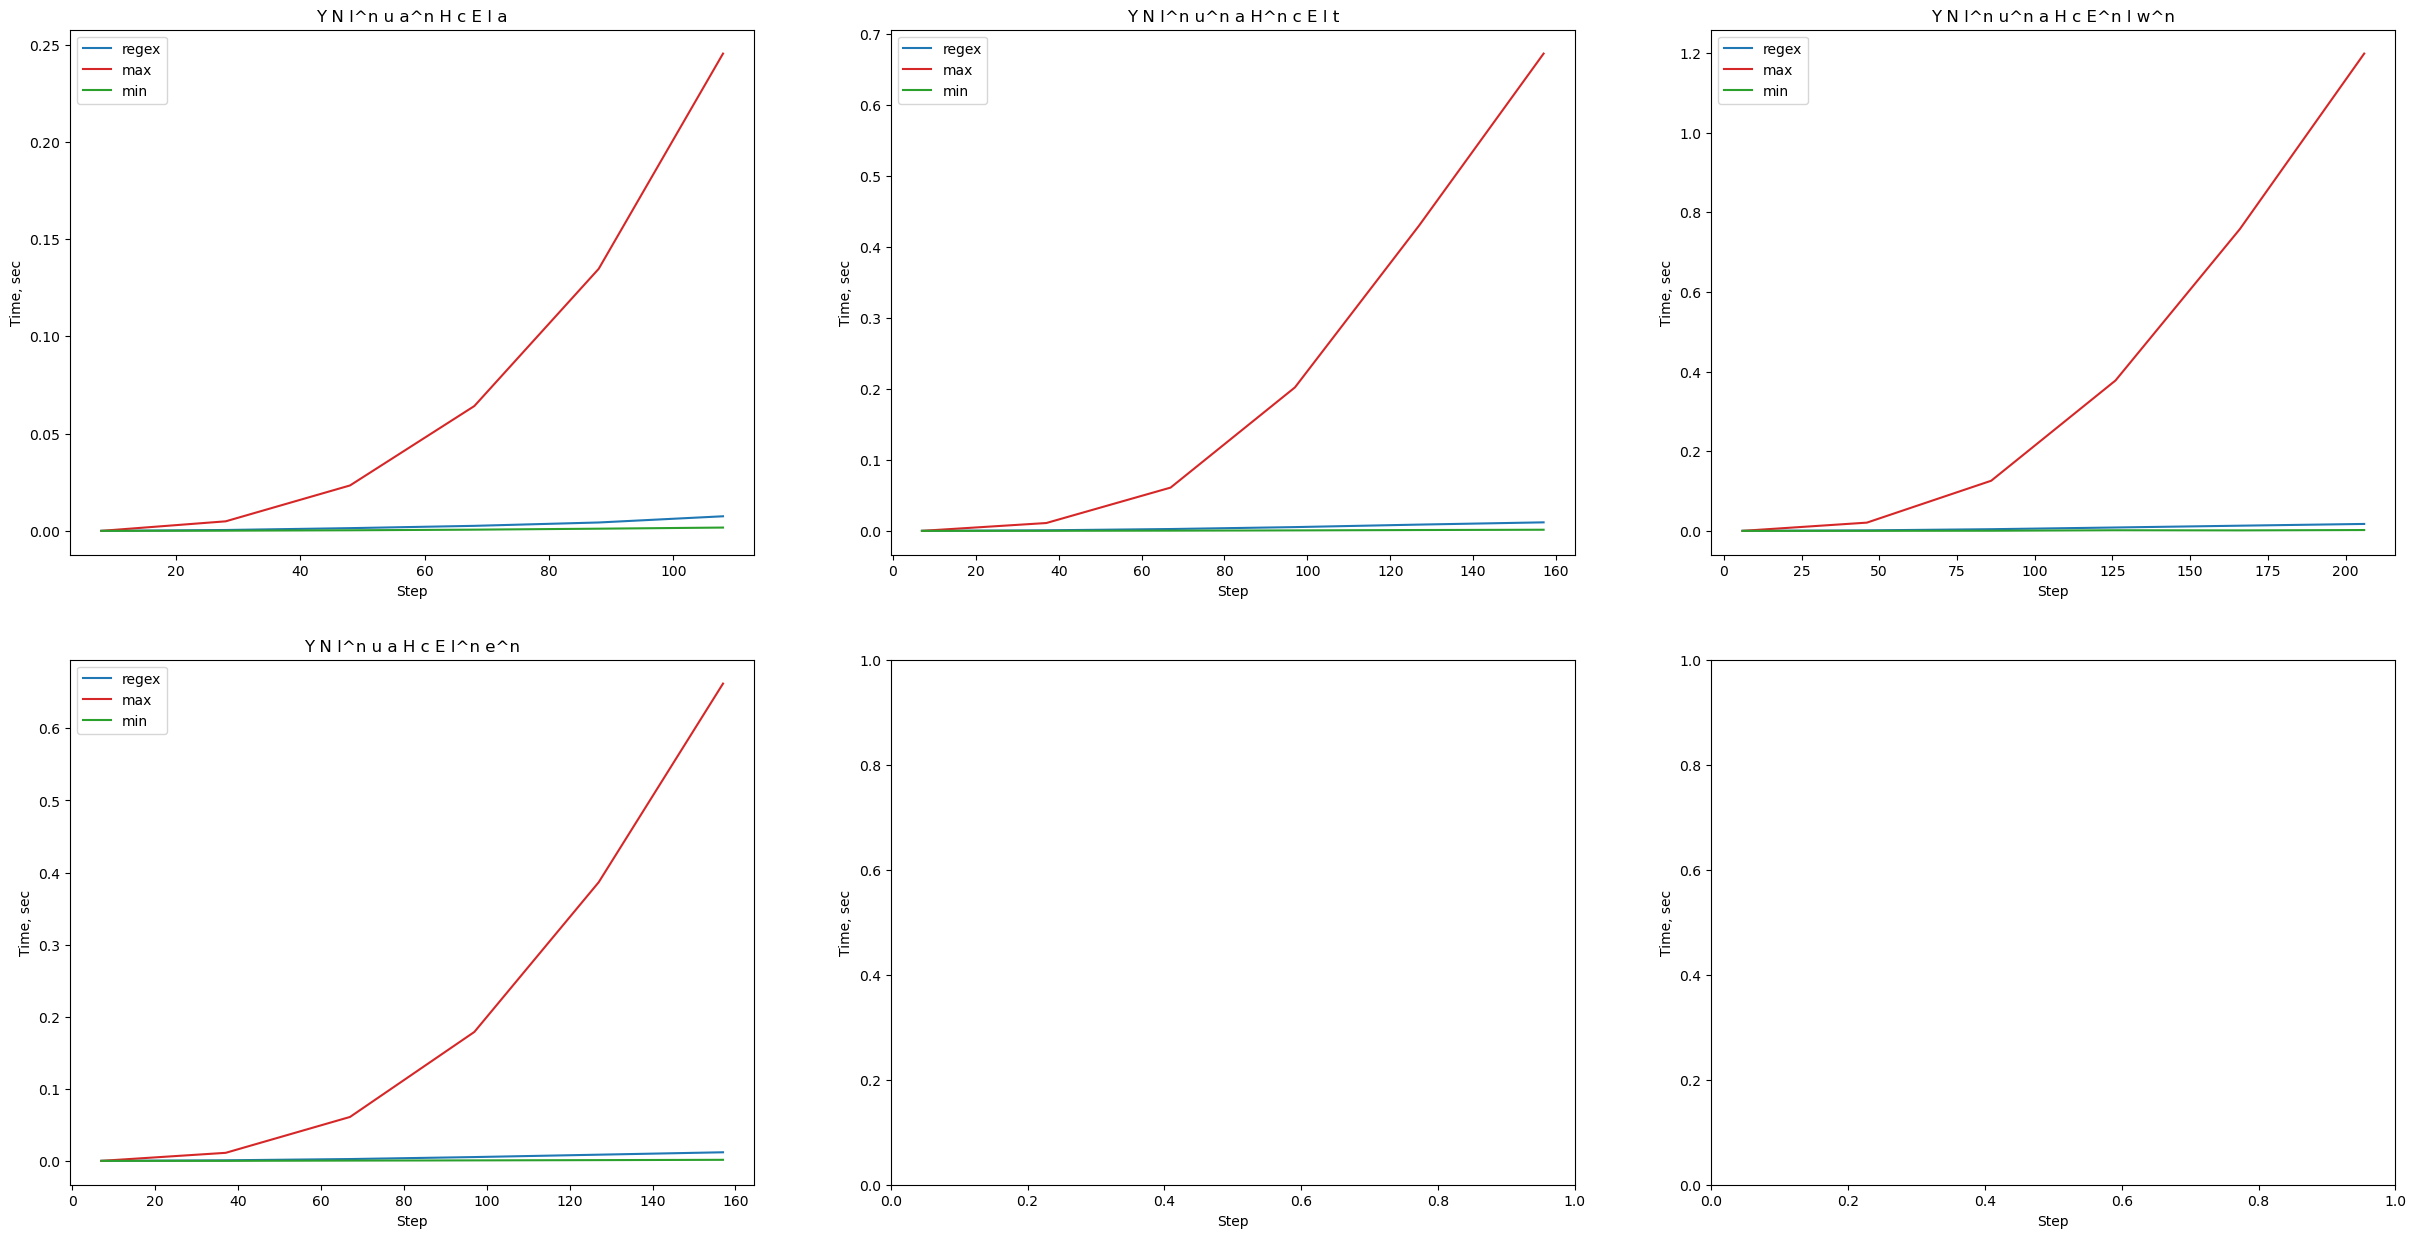

In [92]:
plot_dependencies(check_approximation("YN(l**|u*)a(Hc|E*)|l", 2, max_iter=40))

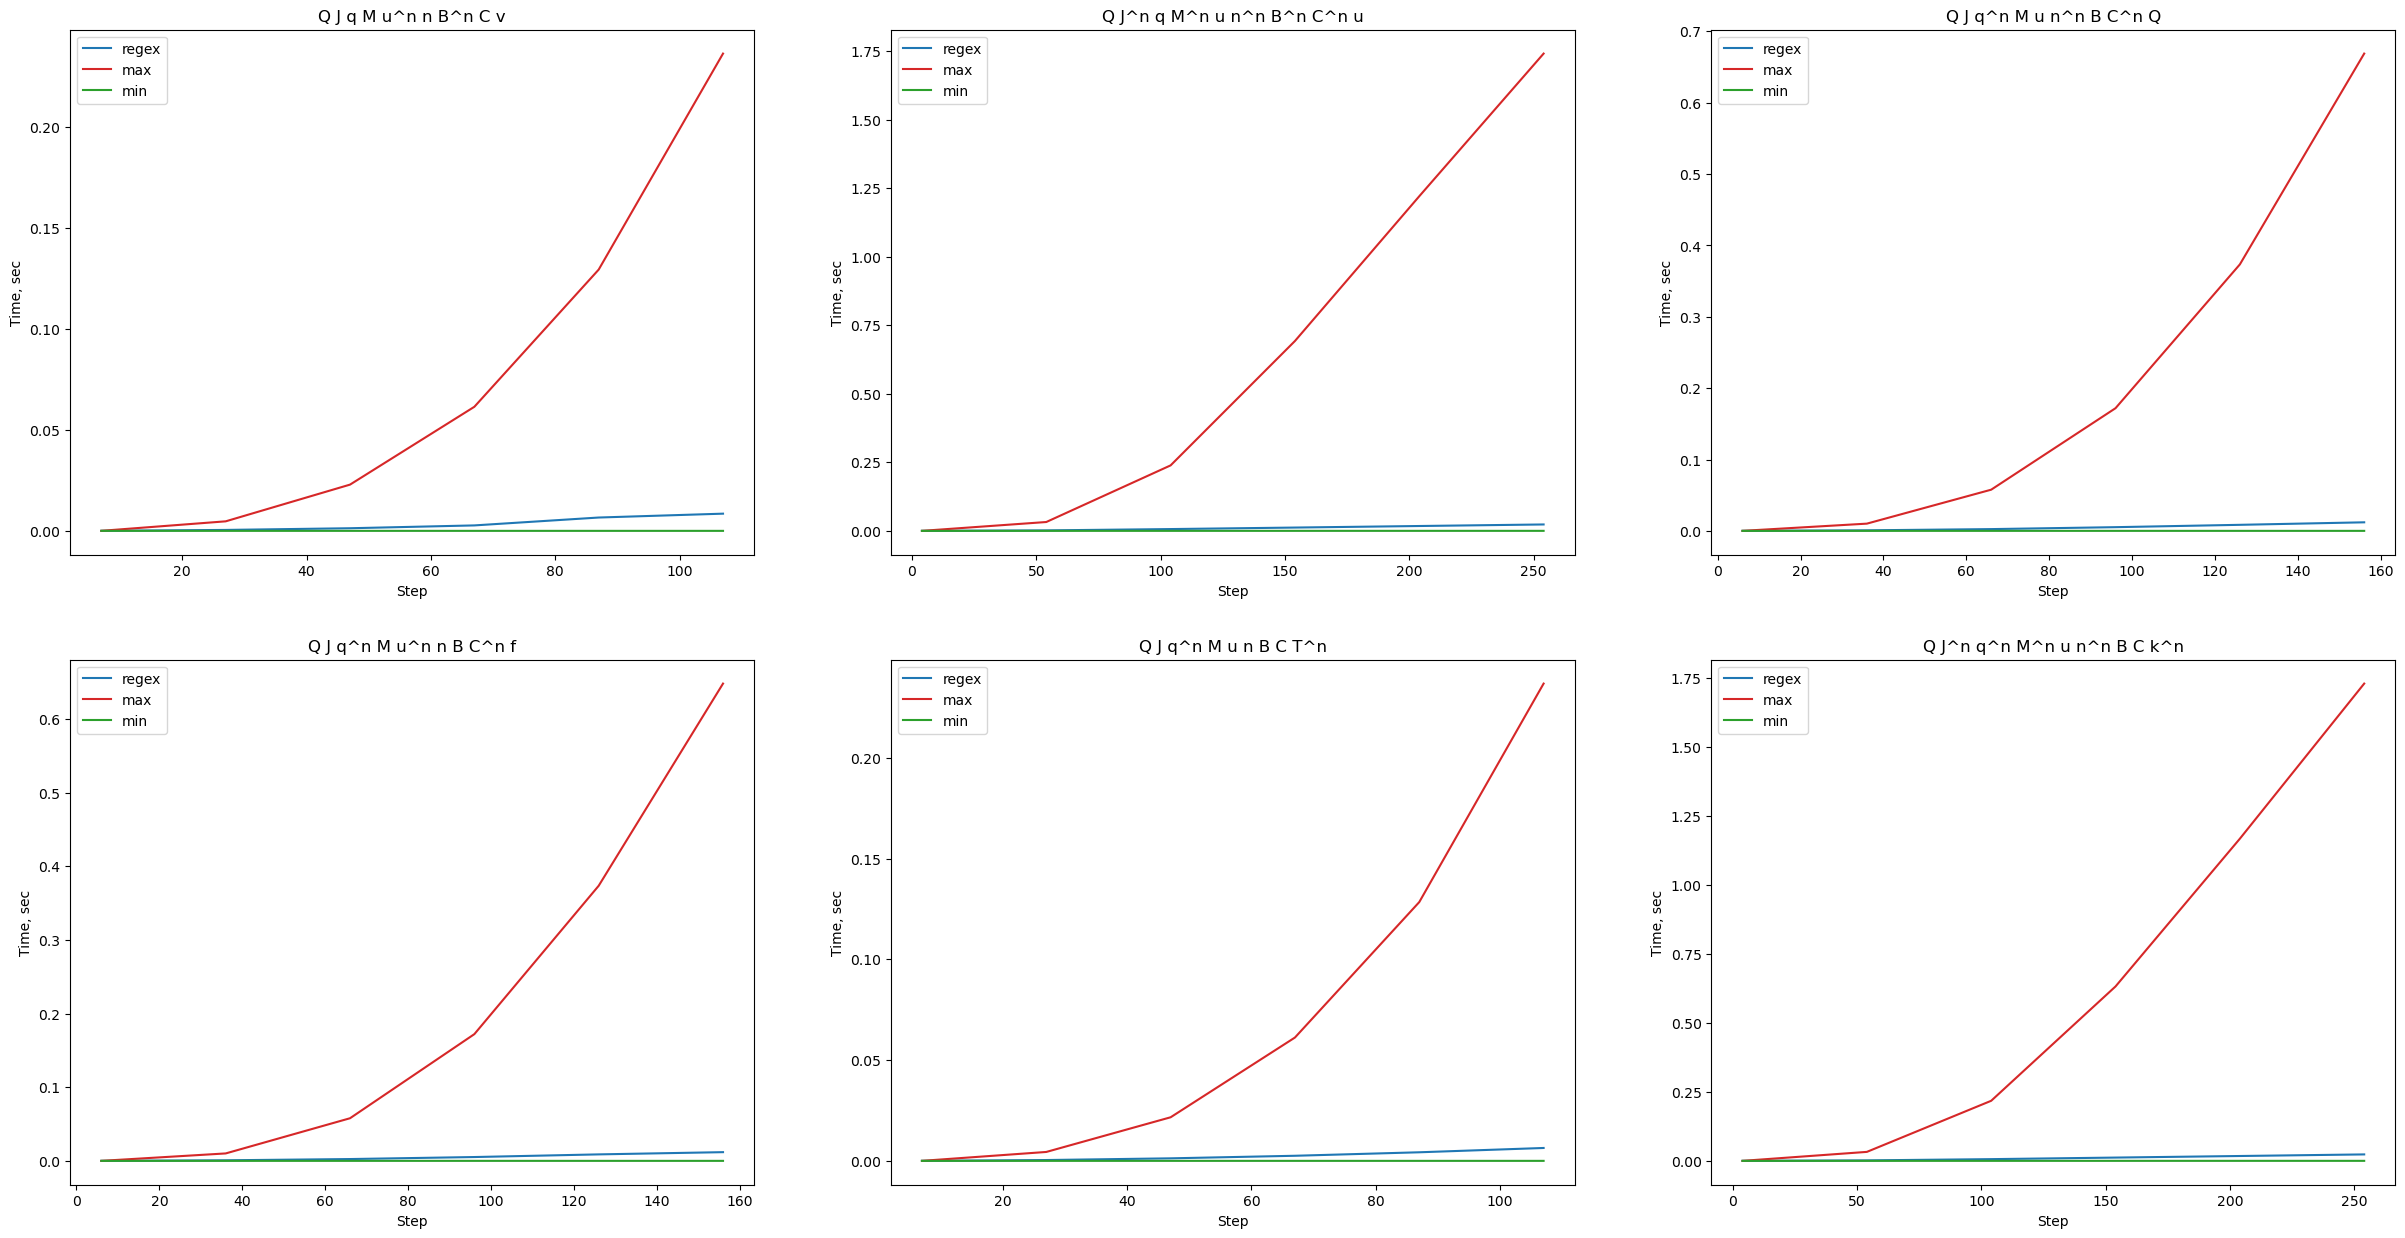

In [77]:
plot_dependencies(check_approximation("QJ*|q|(M(un)*|B)*|C", 2, max_iter=20))

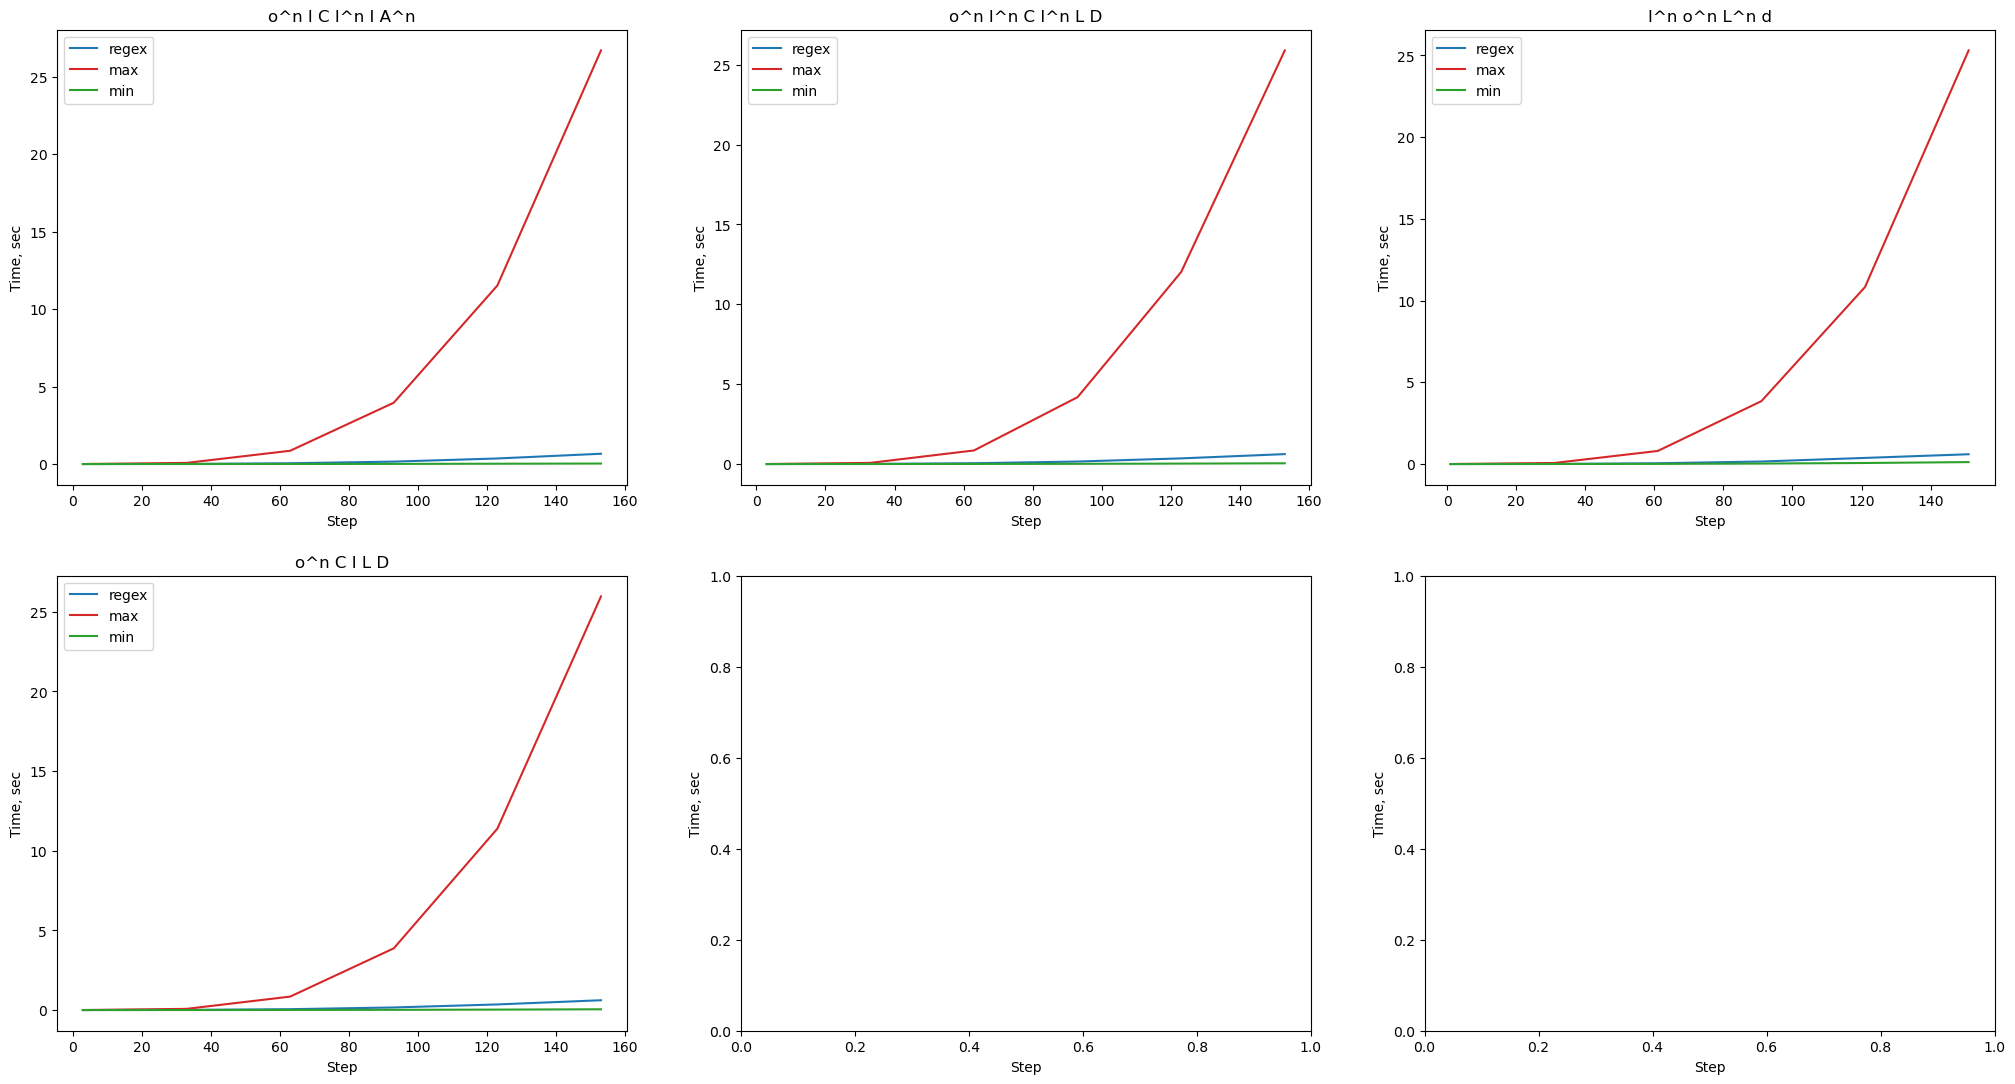

In [65]:
plot_dependencies(check_approximation("(o*|I|dC)**L*|F", 3, max_iter=20))